<a href="https://colab.research.google.com/github/cras-lab/Finance1/blob/main/SamSung_Predict.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

yfinance 라이브러리 설치

In [3]:
pip install -q yfinance

필요한 모듈 임포트

In [39]:
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
from sklearn.model_selection import train_test_split

삼성전자 주가를 받아온 뒤 'Adj Close'열 이름을 adj_close로 변경

In [40]:
df = yf.download("005935.KS", start="2020-01-01", end="2022-2-15", progress=False)

df = df.loc[:,['Adj Close'] ]
df.rename( columns={'Adj Close':'adj_close'}, inplace=True)

훈련과 테스트 분할 

In [41]:
y_train, y_test = train_test_split( df.adj_close, shuffle=False  )

X_train = np.arange(0, len(y_train) )
X_test = np.arange( len(y_train), len(df.adj_close))
n_features = 1

y_train = np.array( y_train )
y_test = np.array( y_test )

train_series = y_train.reshape( (len(y_train), n_features))
test_series = y_test.reshape( (len(y_test), n_features))


그래프 표시

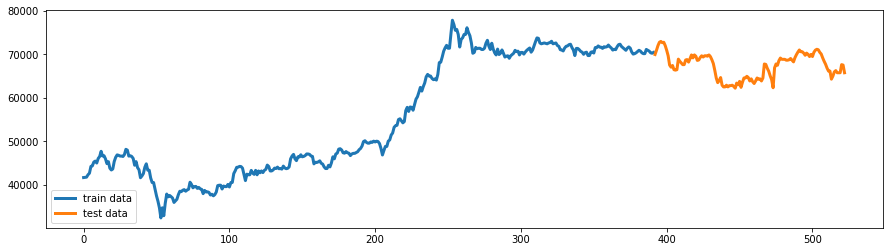

In [42]:
fig, ax = plt.subplots( 1,1, figsize=(15,4))
ax.plot( X_train, y_train, lw=3, label="train data")
ax.plot(X_test, y_test, lw=3, label="test data")
ax.legend( loc="lower left")
plt.show()


주가를 0과 1사이의 값으로 표준화(Normalization)한 다음 그래프 표시

77847.65625 32404.990234375


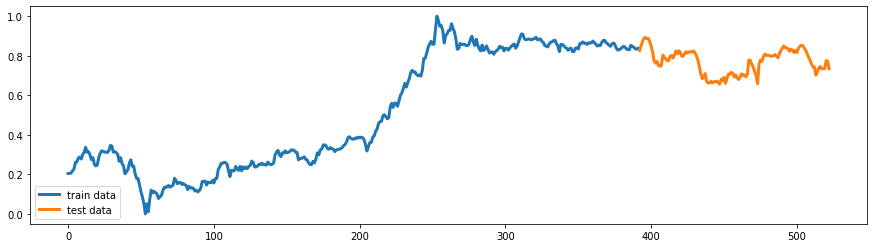

In [43]:
max_price = np.max( train_series )
min_price = np.min( train_series )


print(max_price, min_price)

train_series = (train_series - min_price) / (max_price-min_price)  
test_series = (test_series - min_price) / (max_price-min_price) 

fig, ax = plt.subplots( 1,1, figsize=(15,4))
ax.plot( X_train, train_series, lw=3, label="train data")
ax.plot(X_test, test_series, lw=3, label="test data")
ax.legend( loc="lower left")
plt.show()


TimeseriesGenerator 형태로 변환

In [44]:
from keras.preprocessing.sequence import TimeseriesGenerator
look_back = 20

train_generator = TimeseriesGenerator( train_series, train_series,
                                      length=look_back,
                                      batch_size = 10)


test_generator = TimeseriesGenerator(test_series, test_series,
                                     length= look_back,
                                     batch_size=10)

LSTM 네트워크 구성

In [52]:
from keras.models import Sequential
from keras.layers import Dense, LSTM

n_neurons = 32
model = Sequential()
model.add( LSTM( n_neurons, input_shape=(look_back, n_features)))
model.add( Dense(1))
model.compile( optimizer='adam', loss='mse')

모델을 적합화 한 다음, 예측 생성

In [53]:
model.fit( train_generator, epochs=50, verbose=0)

test_prediction = model.predict( test_generator )

12/12 [==============================] - 1s 4ms/step


예측을 그래프로 표시

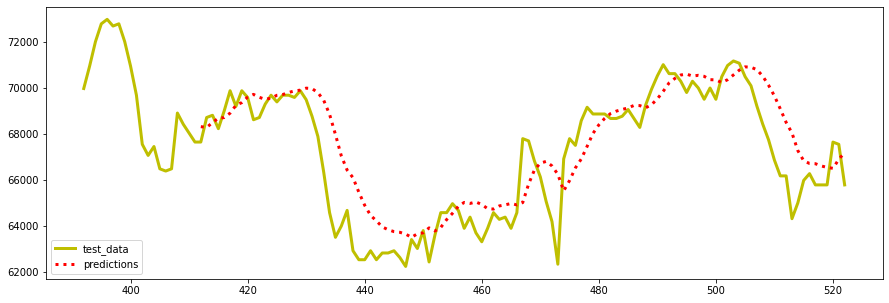

In [54]:
x= np.arange( len(df.adj_close) - len(test_prediction ), len(df.adj_close) )
fig, ax= plt.subplots( 1,1, figsize=(15,5))
ax.plot( X_test, y_test, lw=3, c='y', label='test_data')
ax.plot( x, test_prediction*(max_price-min_price)+min_price,\
        lw=3, c='r', linestyle=':', label='predictions')
ax.legend( loc='lower left')
plt.show()


향후 일정 기간의 주가 예측

1/1 [==============================] - 0s 20ms/step


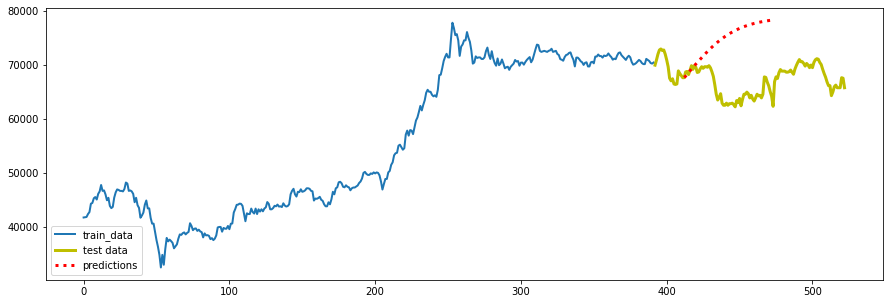

In [17]:
# Extrapolation
days_to_tell = 60
extrapolation = np.zeros(days_to_tell)
seed_batch    = ((y_test[:look_back] - min_price)/(max_price-min_price)).reshape((1,look_back, n_features))
current_batch = seed_batch

# extrapolate the next days_to_tell values
for i in range(days_to_tell):
    predicted_value = model.predict(current_batch)[0]
    extrapolation[i] = predicted_value
    current_batch = np.append(current_batch[:,1:,:],[[predicted_value]],axis=1)

x= np.arange( len(df.adj_close) - len(test_prediction ), len(df.adj_close) - len(test_prediction ) + days_to_tell )
fig, ax = plt.subplots(1, 1, figsize=(15, 5))
ax.plot( X_train, y_train, lw=2, label='train_data')
ax.plot(X_test,y_test, lw=3, c='y', label='test data')
ax.plot( x, extrapolation*(max_price-min_price)+min_price,\
        lw=3, c='r', linestyle=':', label='predictions')

ax.legend(loc="lower left")
plt.show();


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.4/50.4 KB 2.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.8/62.8 KB 6.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 111.0/111.0 KB 10.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 128.2/128.2 KB 13.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.1/4.1 MB 50.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 112.2/112.2 KB 11.2 MB/s eta 0:00:00
